<a href="https://colab.research.google.com/github/kaantopcu/Brain-Tumor-Image-Segmentation/blob/main/notebooks/01_Brain_Tumor_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
try:
    import itk
except ImportError:
    !pip install itk
    import itk

try:
    import itkwidgets
except ImportError:
    !pip install itkwidgets
    import itkwidgets

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import nibabel as nib
import cv2
import keras
from keras.utils import to_categorical
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
%matplotlib inline

sns.set_style('darkgrid')

# Github Repo

In [2]:
!git clone https://github.com/kaantopcu/Brain-Tumor-Image-Segmentation.git

Cloning into 'Brain-Tumor-Image-Segmentation'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 64 (delta 18), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 447.24 KiB | 3.19 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [3]:
os.chdir('Brain-Tumor-Image-Segmentation')

# Importing Custom Functions from the Repo

In [4]:
from projectname.custom_functions import load_case
from projectname.custom_functions import get_labeled_image
from projectname.custom_functions import plot_image_grid

# Explore Data

## Load Images

In [5]:
# Mounting Google Drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
# The path to Covid dataset directory
dataset_path = '/content/gdrive/MyDrive/GesundAI/BraTS'

In [7]:
image_path = '/content/gdrive/MyDrive/GesundAI/BraTS/imagesTr/BRATS_001.nii.gz'
image_obj = nib.load(image_path)
print(f'Type of the image {type(image_obj)}')

Type of the image <class 'nibabel.nifti1.Nifti1Image'>


In [8]:
# Extract the images as numpy ndarray
image_data = image_obj.get_fdata()
type(image_data)

numpy.ndarray

In [9]:
# Get the image shape and print it out
height, width, depth, channels = image_data.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}, channels:{channels}")

The image object has the following dimensions: height: 240, width:240, depth:155, channels:4



    The first 3 dimensions are the X, Y, and Z values for each point in the 3D volume, which is commonly called a voxel.
    The 4th dimension is the values for 4 different sequences
        0: FLAIR: "Fluid Attenuated Inversion Recovery" (FLAIR)
        1: T1w: "T1-weighted"
        2: t1gd: "T1-weighted with gadolinium contrast enhancement" (T1-Gd)
        3: T2w: "T2-weighted"

In [10]:
# Use os.listdir() to get the list of files in the directory
train_files = os.listdir(os.path.join(dataset_path,"imagesTr"))
test_files = os.listdir(os.path.join(dataset_path,"imagesTs"))

print("Number of training images:", len(train_files))
print("Number of test images:", len(test_files))

Number of training images: 484
Number of test images: 266


## Data Labels

In [11]:
# Define the data path and load the data
label_path = '/content/gdrive/MyDrive/GesundAI/BraTS/labelsTr/BRATS_001.nii.gz'
label_obj = nib.load(label_path)
type(label_obj)

nibabel.nifti1.Nifti1Image

In [12]:
# Extract data labels as numpy array
label_array = label_obj.get_fdata()
type(label_array)

numpy.ndarray

In [13]:
# Extract and print out the shape of the labels data
height, width, depth = label_array.shape
print(f"Dimensions of labels data array height: {height}, width: {width}, depth: {depth}")
print(f'With the unique values: {np.unique(label_array)}')
print("""Corresponding to the following label categories:
0: for normal
1: for edema
2: for non-enhancing tumor
3: for enhancing tumor""")

Dimensions of labels data array height: 240, width: 240, depth: 155
With the unique values: [0. 1. 2. 3.]
Corresponding to the following label categories:
0: for normal
1: for edema
2: for non-enhancing tumor
3: for enhancing tumor


In [14]:
# Use os.listdir() to get the list of files in the directory
train_labels = os.listdir(os.path.join(dataset_path,"labelsTr"))


print("Number of training labels:", len(train_labels))

Number of training labels: 484


## Data Visualization

Plotting Layer 17 Channel 0 of Image


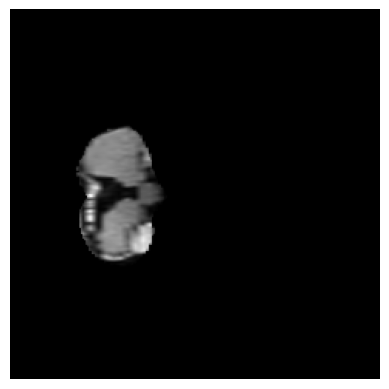

In [36]:
# Select random layer number
maxval = 154
i = np.random.randint(0, maxval)
# Define a channel to look at
channel = 0
print(f"Plotting Layer {i} Channel {channel} of Image")
plt.imshow(image_data[:, :, i, channel], cmap='gray')
plt.axis('off');

In [15]:
image_data.shape[2] - 1

154

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

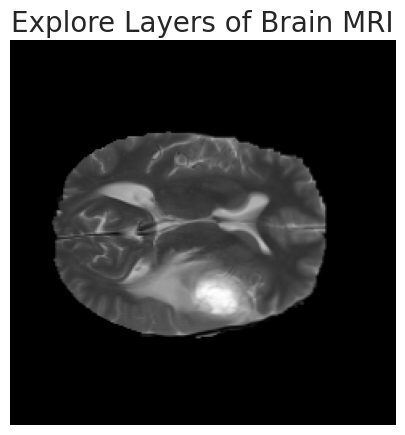

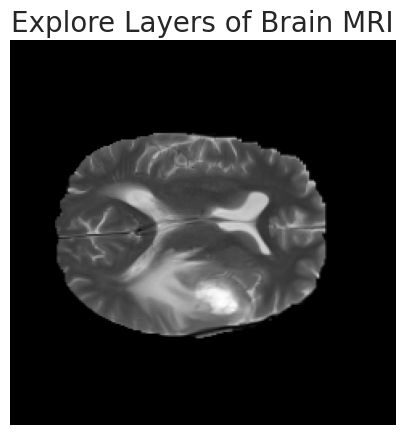

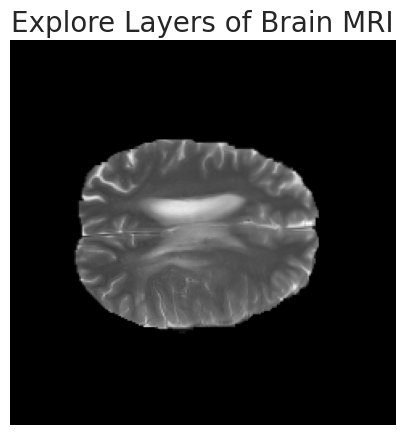

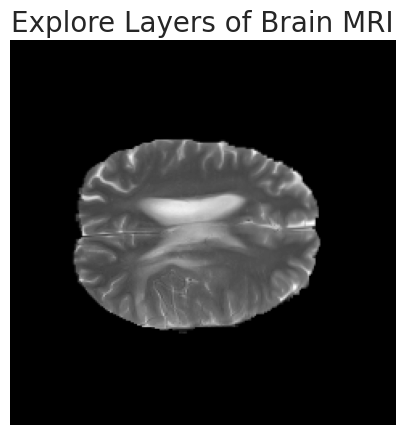

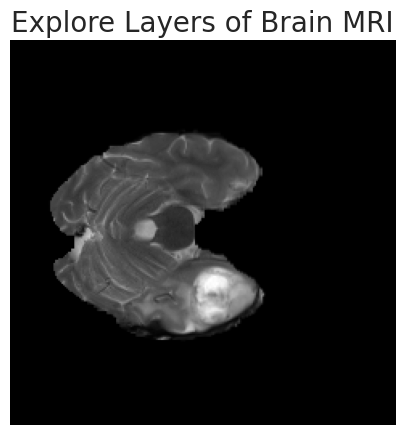

In [12]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 3
    plt.imshow(image_data[:, :, layer, channel], cmap='gray');
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, image_data.shape[2] - 1));

### Visualize Specific Layer

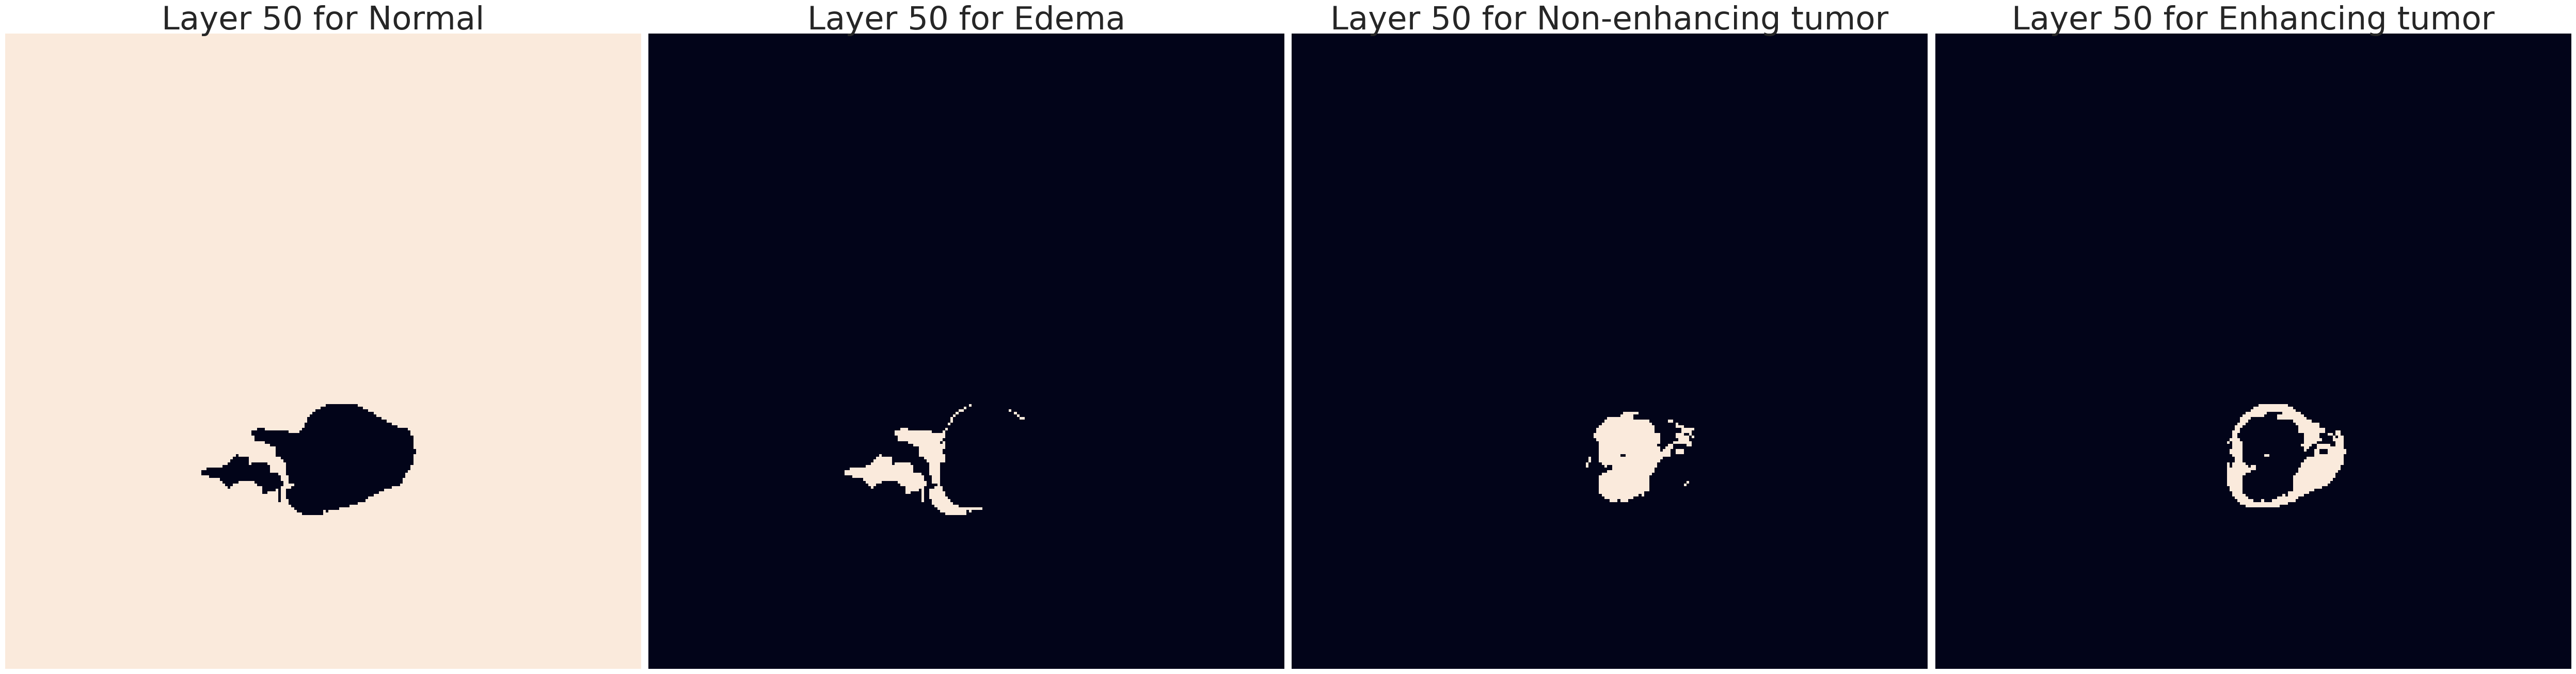

In [16]:
# Define a single layer for plotting
layer = 50
# Define a dictionary of class labels
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3.
}
# Set up for plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
for i in range(4):
    img_label_str = list(classes_dict.keys())[i]
    img = label_array[:,:,layer]
    mask = np.where(img == classes_dict[img_label_str], 255, 0)
    ax[i].imshow(mask)
    ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
    ax[i].axis('off')
plt.tight_layout()

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

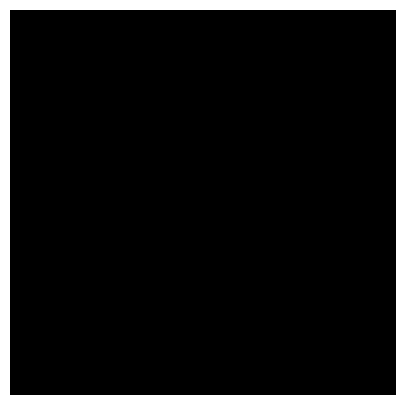

In [17]:
# Create button values
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info',

)
# Create layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)


# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(label_array[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

# No-name

The colors correspond to each class:

    Red is edema
    Green is a non-enhancing tumor
    Blue is an enhancing tumor.


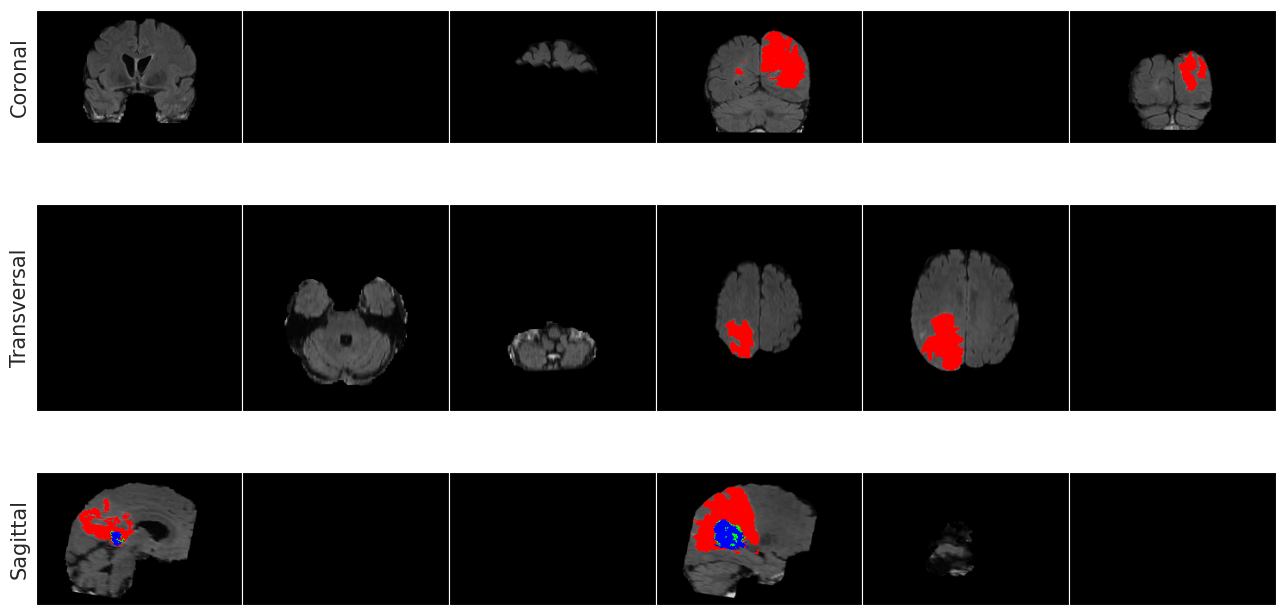

In [18]:
image, label = load_case(dataset_path + "/imagesTr/BRATS_003.nii.gz", dataset_path + "/labelsTr/BRATS_003.nii.gz")
image = get_labeled_image(image, label)

plot_image_grid(image)